# Data Analysis and NLP Tasks

- Sentiment Analysis
- Text Summarization
- Exploratory Data Analysis (EDA)

## Imports

In [1]:
import os
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob

## Data Loading

Load the cleaned data from the previous notebook.

In [2]:
data = pd.read_csv("../data/processed/cleantech_processed.csv")
data.head()

,title,date,author,content,domain,url,content_cleaned,content_tokenized,content_stemmed,content_lemmatized
0,Qatar to Slash Emissions as LNG Expansion Adva...,2021-01-13,NaN,"[""Qatar Petroleum ( QP) is targeting aggressiv...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,qatar petroleum qp targeting aggressive cuts g...,"['qatar', 'petroleum', 'qp', 'targeting', 'agg...",qatar petroleum qp target aggress cut greenhou...,qatar petroleum qp targeting aggressive cut gr...
1,India Launches Its First 700 MW PHWR,2021-01-15,NaN,"[""• Nuclear Power Corp. of India Ltd. ( NPCIL)...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,nuclear power corp india ltd npcil synchronize...,"['nuclear', 'power', 'corp', 'india', 'ltd', '...",nuclear power corp india ltd npcil synchron ka...,nuclear power corp india ltd npcil synchronize...
2,New Chapter for US-China Energy Trade,2021-01-20,NaN,"[""New US President Joe Biden took office this ...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,new us president joe biden took office week us...,"['new', 'us', 'president', 'joe', 'biden', 'to...",new us presid joe biden took offic week uschin...,new u president joe biden took office week usc...
3,Japan: Slow Restarts Cast Doubt on 2030 Energy...,2021-01-22,NaN,"[""The slow pace of Japanese reactor restarts c...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,slow pace japanese reactor restarts continues ...,"['slow', 'pace', 'japanese', 'reactor', 'resta...",slow pace japanes reactor restart continu cast...,slow pace japanese reactor restarts continues ...
4,NYC Pension Funds to Divest Fossil Fuel Shares,2021-01-25,NaN,"[""Two of New York City's largest pension funds...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,two new york citys largest pension funds say d...,"['two', 'new', 'york', 'citys', 'largest', 'pe...",two new york citi largest pension fund say div...,two new york city largest pension fund say div...


In [3]:
data.columns

Index(['title', 'date', 'author', 'content', 'domain', 'url',
       'content_cleaned', 'content_tokenized', 'content_stemmed',
       'content_lemmatized'],
      dtype='object')

## Sentiment Analysis

The goal of this step is to quantify the sentiment expressed in the text data, providing a numerical value that reflects whether the sentiment is positive, negative, or neutral (-1.0 indicates a negative sentiment, 1.0 indicates a positive sentiment, and 0 indicates a neutral sentiment).

**Example**

For instance, if content_cleaned has an entry like "This technology is amazing!", the get_sentiment function would return a positive polarity score (e.g., 0.8). Conversely, if the entry is "This technology is terrible!", it might return a negative polarity score (e.g., -0.7). This transformation allows for quantifying and analyzing sentiments in the dataset systematically.

In [4]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis to the 'content' column
data['sentiment'] = data['content_cleaned'].apply(get_sentiment)

In [5]:
print(data['sentiment'].describe())

count    9593.000000
mean        0.111761
std         0.061180
min        -0.247789
25%         0.072533
50%         0.108145
75%         0.148359
max         0.458333
Name: sentiment, dtype: float64


We can visualize the sentiment values to help us understand their distribution visually

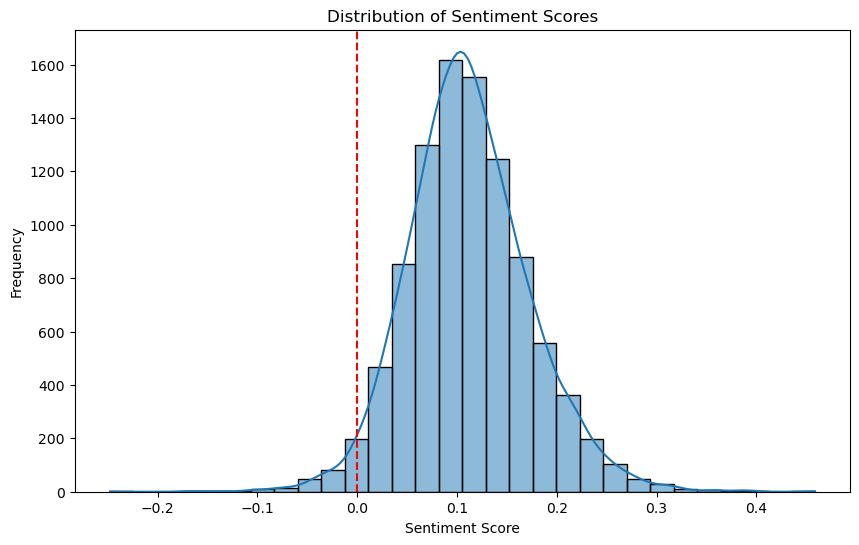

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(data['sentiment'], bins=30, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--')  # Indicate neutral sentiment
plt.show()

This histogram shows how many entries have positive, negative or neutral sentiments. The red line indicates the neutral sentiment threshold (0). The histogram looks like a normal distribution, with the mean value being around 0.1. 

We can count how many entries are positive, negative or neutral based on the sentiment scores:

In [7]:
# Classify sentiment
data['sentiment_category'] = pd.cut(data['sentiment'], bins=[-1, -0.1, 0.1, 1], labels=['Negative', 'Neutral', 'Positive'])

# Count the occurrences of each sentiment category
sentiment_counts = data['sentiment_category'].value_counts()
print(sentiment_counts)

sentiment_category
Positive    5382
Neutral     4200
Negative      11
Name: count, dtype: int64


Our dataset contains a date column, so we can analyze how sentiment changes over time

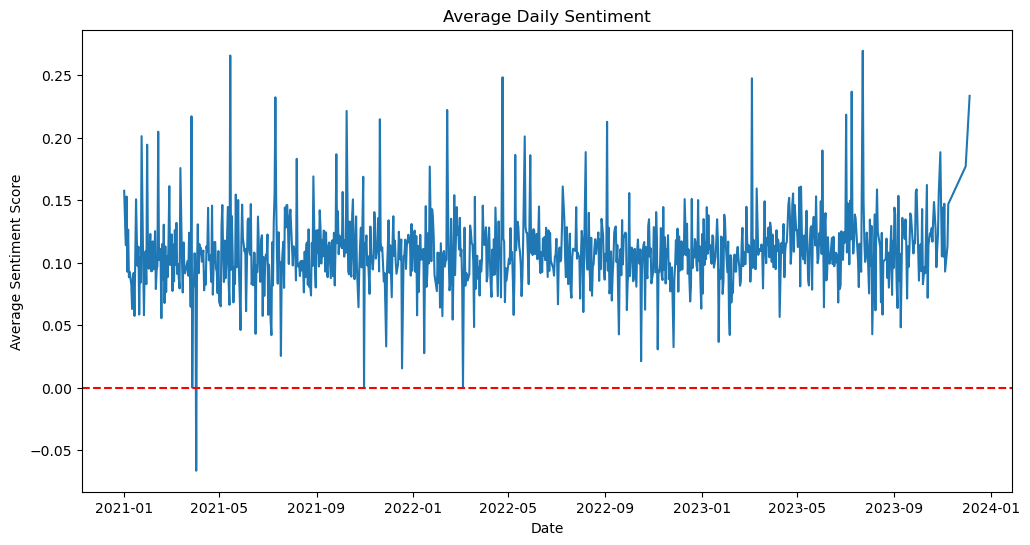

In [8]:
# Convert 'date' column to datetime format if not already done
data['date'] = pd.to_datetime(data['date'])

# Group by date and calculate the average sentiment
daily_sentiment = data.groupby(data['date'].dt.date)['sentiment'].mean()

# Plotting the daily sentiment
plt.figure(figsize=(12, 6))
daily_sentiment.plot()
plt.title('Average Daily Sentiment')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.axhline(y=0, color='red', linestyle='--')  # Indicate neutral sentiment
plt.show()

## Text Summarization

Types of Text Summarization:
- Extractive Summarization: This method selects key sentences or phrases directly from the text to create a summary. It aims to retain important information without altering the original wording. Techniques often include sentence ranking based on features like term frequency, sentence position, or using models like TF-IDF.
- Abstractive Summarization: This approach generates new sentences to convey the main ideas of the text. It requires a deeper understanding of the content and may involve techniques such as paraphrasing and generating new phrases. Models like T5, BART, or GPT are commonly used for this purpose.

In [9]:
data_sample = data["content_cleaned"].head()
data_sample

0    qatar petroleum qp targeting aggressive cuts g...
1    nuclear power corp india ltd npcil synchronize...
2    new us president joe biden took office week us...
3    slow pace japanese reactor restarts continues ...
4    two new york citys largest pension funds say d...
Name: content_cleaned, dtype: object

In [10]:
from transformers import pipeline

# Load the summarization model
summarizer = pipeline("summarization")

/Users/alexanderschilling/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [11]:
def summarize_text(text):
    summary = summarizer(text, max_length=130, min_length=30, do_sample=False)
    return summary[0]['summary_text']

for text in data_sample:
    print(summarize_text(text))

 qatar petroleum qp targeting aggressive cuts greenhouse gas emissions prepares launch phase 2 planned 48 million ton per year lng expansion . Phase 2 planned to raise production capacity 16 million tons per year . Company also plans build 1.6 gigawatts solar energy capacity .
 niw sep.1820 news tweeted anil kakodkar former chairman department atomic energy said 15 units design follow three currently constructionanother kakrapar two rajasthan plant followed two greenfield gorakhpur site haryana planned 10 units . niw dec.1120 inaugural us small modular reactor smr project moved second phase fluor nuscale subsidiary announcing jan 11 per agreements utah associated municipal power systems uamps develop higher maturity cost estimates .
 uschina relationship worst decades energy come play bigger role relationship ever rising chinese imports us oil lng could serve foundation fresh discussions . china part phase 1 trade deal would lift us tariffs chinese products biden november us presidenti

## Explorative Data Analysis

**Content Length**

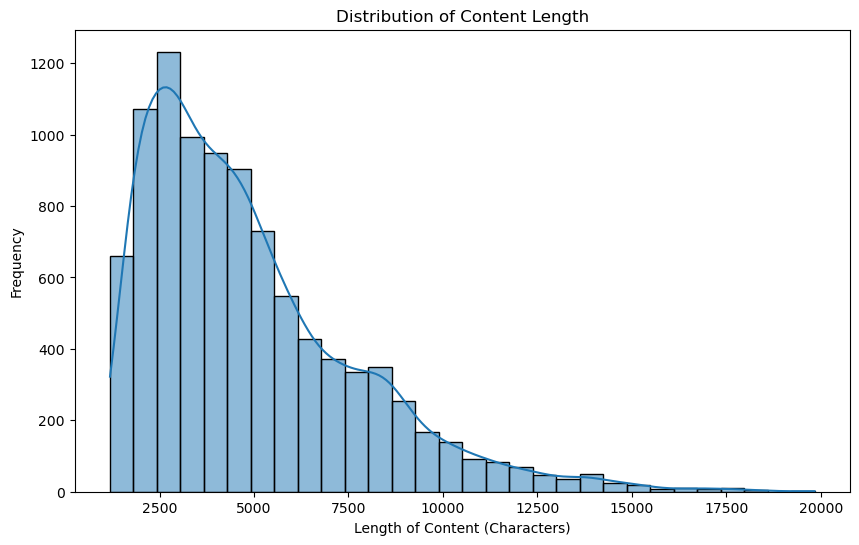

Max:  19836
Min:  1188


In [12]:
# Add a column for the length of each content
data['content_length'] = data['content'].apply(len)

# Visualize the distribution of content length
plt.figure(figsize=(10, 6))
sns.histplot(data['content_length'], bins=30, kde=True)
plt.title('Distribution of Content Length')
plt.xlabel('Length of Content (Characters)')
plt.ylabel('Frequency')
plt.show()

print("Max: ", data['content_length'].max())
print("Min: ", data['content_length'].min())

**Most Common Words**
- We can analyze and visualize the most common words in our dataset

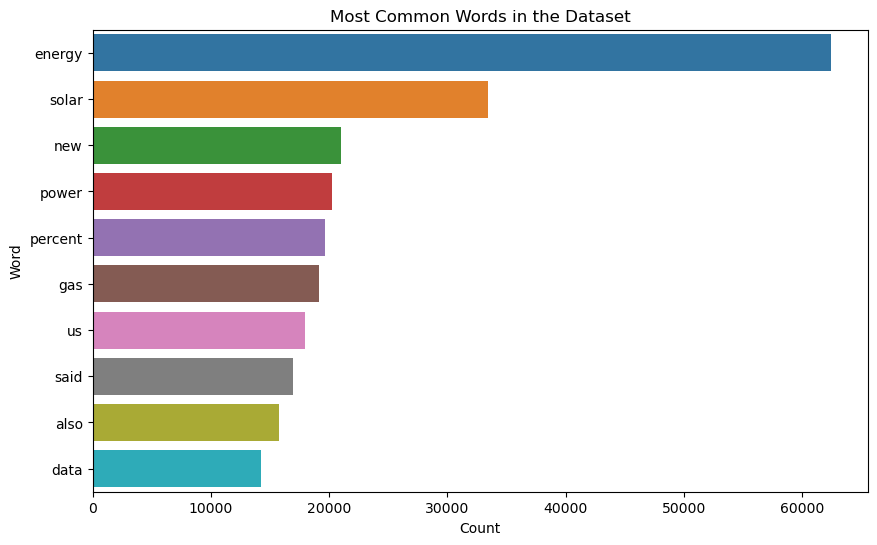

In [36]:
# Combine all cleaned content into a single string
all_words = ' '.join(data['content_cleaned'])
word_counts = Counter(all_words.split())
common_words = word_counts.most_common(10)

# Convert to DataFrame for visualization
common_words_df = pd.DataFrame(common_words, columns=['word', 'count'])

# Plotting the most common words
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='word', data=common_words_df)
plt.title('Most Common Words in the Dataset')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

**Relationship Between Variables**

Explore relationships between variables, such as how sentiment scores correlate with content length or publication dates.

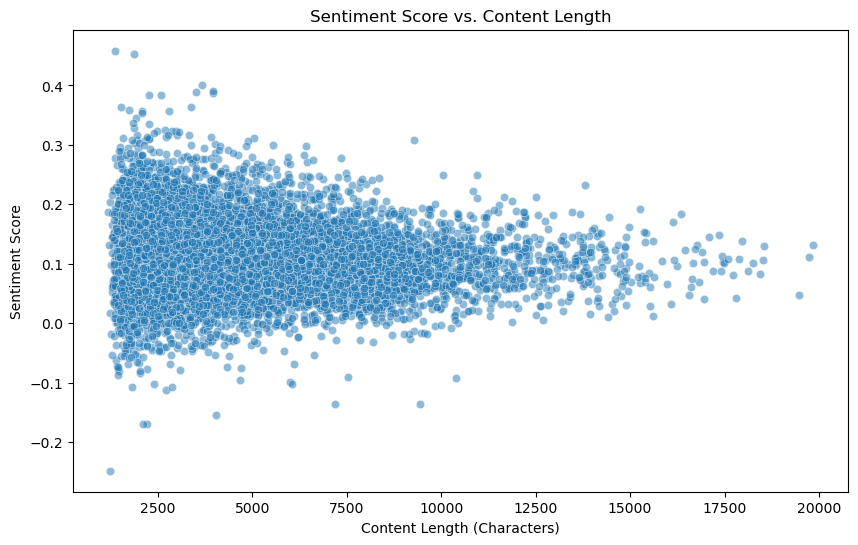

In [14]:
# Scatter plot of sentiment score vs. content length
plt.figure(figsize=(10, 6))
sns.scatterplot(x='content_length', y='sentiment', data=data, alpha=0.5)
plt.title('Sentiment Score vs. Content Length')
plt.xlabel('Content Length (Characters)')
plt.ylabel('Sentiment Score')
plt.show()

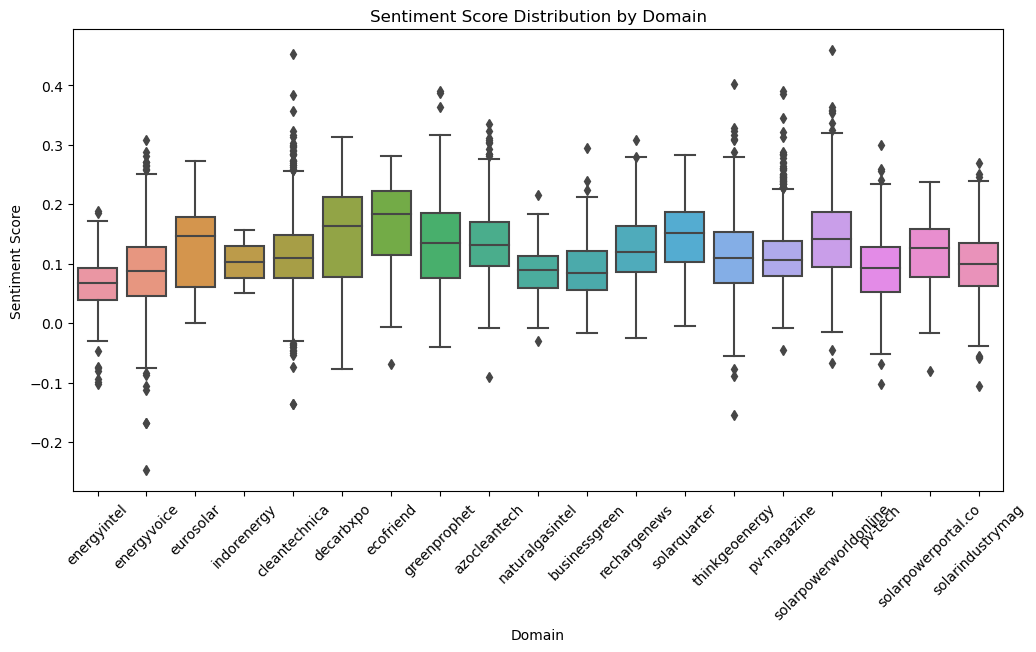

In [15]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='domain', y='sentiment', data=data)
plt.title('Sentiment Score Distribution by Domain')
plt.xlabel('Domain')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.show()